# An example of GPinv: For the regression purpose.

This notebook briefly shows a regression usage by GPflow

*Keisuke Fujii 7th Oct. 2016*

In this notebook, we show some examples of GPinv for the regression usage.

We show

+ Simple regression, that can be done also by usual Gaussian Process.      
+ Regression with non-Gaussian likelihood.
+ More flexible regression with the expert model.

## Import several libraries including GPinv

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
# Import GPinv
import GPinv
# Import GPflow as comparison
import GPflow

# Simple regression

## Synthetic data

In [2]:
X = np.linspace(0,6,40).reshape(-1,1)
Y = np.sin(X) + np.random.randn(40,1)*0.1

## GPflow.gpr.GPR

In [3]:
m_gpflow = GPflow.gpr.GPR(X, Y, GPflow.kernels.RBF(1))
m_gpflow.optimize()

      fun: -15.20633848080001
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.92393799e-05,  -7.05729859e-06,  -9.16348091e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 11
   status: 0
  success: True
        x: array([-4.28651646,  1.66333704,  0.59448408])

In [4]:
X_new = np.linspace(-0.1,6.1,40).reshape(-1,1)
f_mu, f_var = m_gpflow.predict_f(X_new)

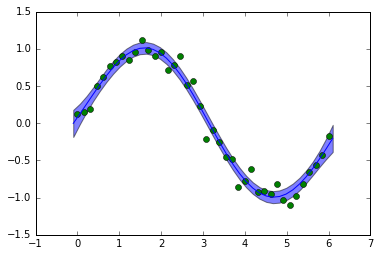

In [5]:
plt.plot(X, Y, 'go')
plt.fill_between(X_new.flatten(), (f_mu+2*np.sqrt(f_var)).flatten(), (f_mu-2*np.sqrt(f_var)).flatten(), alpha=0.5)
plt.plot(X_new, f_mu,'b')

## GPinv.stvgp

In GPinv, we need custom likelihood, where at least the conditional likelihood of the data (**logp**) is specified.

The likelihood class should inherite GPinv.likelihood.Likelihood.

In [6]:
class GaussianLikelihood(GPinv.likelihoods.Likelihood):
    def __init__(self):
        GPinv.likelihoods.Likelihood.__init__(self)
        # variance parameter is assigned as GPinv.param.Param
        self.variance = GPinv.param.Param(1, GPinv.transforms.positive)
    
    def logp(self, F, Y):
        return GPinv.densities.gaussian(Y, F, self.variance)

In [7]:
# In GPinv, kernel object is slightly different from that in GPflow.
# The GPinv kernel requires output_dim, which is the output dimension of the kernel.
# In this case, it is 1.

m_gpinv = GPinv.stvgp.StVGP(X, Y, GPinv.kernels.RBF(1, output_dim=1), likelihood=GaussianLikelihood())

In [8]:
# StVGP uses stochastic approximation of the evidence lower bound, we need stochastic optimizer by tensorflow

trainer = tf.train.AdamOptimizer(learning_rate=0.005)
m_gpinv.optimize(trainer, maxiter=2000)

     fun: -13.643394517624728
     jac: array([  0.37415974, -11.99691391,   0.23588703, ...,   0.19120725,
        -0.06888874,  -0.36884547])
 message: 'Finished iterations.'
  status: 'Finished iterations.'
 success: True
       x: array([-0.47705783,  1.35196851, -4.20354479, ..., -0.02864552,
       -0.01180834,  0.99550482])

In [9]:
# GPinv model also has predict_f method.
f_mu2, f_var2 = m_gpinv.predict_f(X_new)

### Compare results

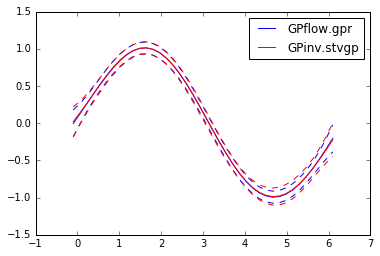

In [10]:
plt.plot(X_new, f_mu+2*np.sqrt(f_var), '--b',
         X_new, f_mu-2*np.sqrt(f_var), '--b')
plt.plot(X_new, f_mu, '-b', label='GPflow.gpr')

plt.plot(X_new, f_mu2+2*np.sqrt(f_var2), '--r',
         X_new, f_mu2-2*np.sqrt(f_var2), '--r')
plt.plot(X_new, f_mu2, '-r', label='GPinv.stvgp')

plt.legend()

These two models show almost identical results, 
although GPinv.stvgp needs more calculation time.

# Regression with non-Gaussian likelihood

## GPflow.vgp

In [11]:
Y = np.sin(X) + np.random.randn(X.shape[0],X.shape[1]) * 0.1
Y[np.random.randint(0,X.shape[0],5),0] = np.random.randn(5) # Add non-Gaussian noise

## GPflow.vgp.VGP

For non-Gaussian likelihood, GPflow.vgp.VGP can be used.

We assume Student's-T likelihood.

In [12]:
m_gpflow = GPflow.vgp.VGP(X, Y, GPflow.kernels.RBF(1), likelihood=GPflow.likelihoods.StudentT())
_= m_gpflow.optimize()

In [13]:
X_new = np.linspace(-0.1,6.1,40).reshape(-1,1)
f_mu, f_var = m_gpflow.predict_f(X_new)

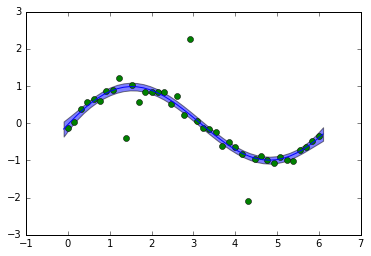

In [14]:
plt.plot(X, Y, 'go')
plt.fill_between(X_new.flatten(), (f_mu+2*np.sqrt(f_var)).flatten(), (f_mu-2*np.sqrt(f_var)).flatten(), alpha=0.5)
plt.plot(X_new, f_mu,'b')

## GPinv.stvgp

In GPinv, we need custom likelihood, where at least the conditional likelihood of the data (**logp**) is specified.

The likelihood class should inherite GPinv.likelihood.Likelihood.

In [15]:
class StudentLikelihood(GPinv.likelihoods.Likelihood):
    def __init__(self):
        GPinv.likelihoods.Likelihood.__init__(self)
        # variance parameter is assigned as GPinv.param.Param
        self.variance = GPinv.param.Param(1, GPinv.transforms.positive)
    
    def logp(self, F, Y):
        return GPinv.densities.student_t(Y, F, self.variance, deg_free=np.ones(1)*3)

In [16]:
# In GPinv, kernel object is slightly different from that in GPflow.
# The GPinv kernel requires output_dim, which is the output dimension of the kernel.
# In this case, it is 1.

m_gpinv = GPinv.stvgp.StVGP(X, Y, GPinv.kernels.RBF(1, output_dim=1), likelihood=StudentLikelihood())

In [17]:
# StVGP uses stochastic approximation of the evidence lower bound, we need stochastic optimizer by tensorflow

trainer = tf.train.AdamOptimizer(learning_rate=0.002)
m_gpinv.optimize(trainer, maxiter=2000)

     fun: 12.046533625746235
     jac: array([ 1.0272911 ,  2.45101327,  4.35236501, ...,  0.14010933,
       -0.16567598,  0.511257  ])
 message: 'Finished iterations.'
  status: 'Finished iterations.'
 success: True
       x: array([-1.99573325,  1.21062729, -0.24581069, ...,  0.03131787,
        0.01057999, -0.01110214])

In [18]:
# GPinv model also has predict_f method.
f_mu2, f_var2 = m_gpinv.predict_f(X_new)

### Compare results

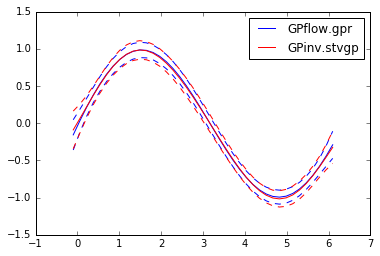

In [19]:
plt.plot(X_new, f_mu+2*np.sqrt(f_var), '--b',
         X_new, f_mu-2*np.sqrt(f_var), '--b')
plt.plot(X_new, f_mu, '-b', label='GPflow.gpr')

plt.plot(X_new, f_mu2+2*np.sqrt(f_var2), '--r',
         X_new, f_mu2-2*np.sqrt(f_var2), '--r')
plt.plot(X_new, f_mu2, '-r', label='GPinv.stvgp')

plt.legend()

These two models show very similar results.

# More flexible regression.

Here we demonstrate more flexible regression.

In this example, we try to fit the data where the length scale varies in position. 

In [20]:
X = np.linspace(0,6,100).reshape(-1,1)
Y = np.sin(0.1*X*X*X) + np.random.randn(*X.shape)*0.1

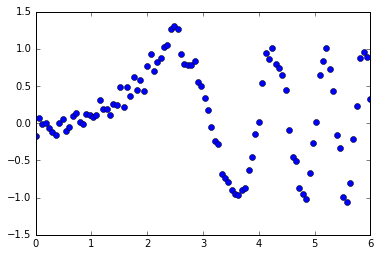

In [21]:
plt.plot(X,Y,'o')

## GPflow.gpr

In [22]:
m_gpflow = GPflow.gpr.GPR(X, Y, GPflow.kernels.RBF(1))
m_gpflow.optimize()

      fun: -22.392089917931237
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -7.22812075e-05,  -2.54333735e-04,   2.68453147e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 15
   status: 0
  success: True
        x: array([-4.62994097, -0.53976393, -1.44514157])

In [23]:
X_new = np.linspace(-0.1,6.1,200).reshape(-1,1)
f_mu, f_var = m_gpflow.predict_f(X_new)

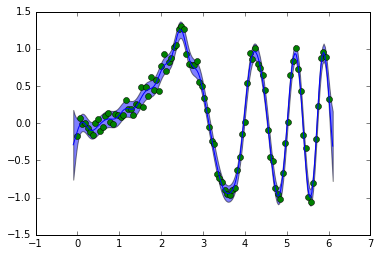

In [24]:
plt.plot(X, Y, 'go')
plt.fill_between(X_new.flatten(), (f_mu+2*np.sqrt(f_var)).flatten(), (f_mu-2*np.sqrt(f_var)).flatten(), alpha=0.5)
plt.plot(X_new, f_mu,'b')

## GPinv.stvgp

In GPinv, we can use more flexible model.

Here, we demonstrate the expart function model by GPinv.
We assume three latent functions, one of which has the shorter lengthscale ($f_s(x)$), 
another with longer lengthscale ($f_l(x)$).

The last one has largest lengthscale, $r(x)$ and represents the fraction of $f_s(x)$ and $f_l(x)$ to be contributed with respect to the position,
i.e.

$$
f(x) = \frac{1}{1+e^{r(x)}} f_s(x) + \frac{1}{1+e^{-r(x)}} f_l(x)
$$

### Likelihood
Such complex relations between multiple latent functions can be implemented in the **Likelihood** class.

In [25]:
class ExpertLikelihood(GPinv.likelihoods.Likelihood):
    def __init__(self):
        GPinv.likelihoods.Likelihood.__init__(self)
        self.variance = GPinv.param.Param(1, GPinv.transforms.positive)
        
    def F(self, F):
        """
        F has N x n x 3 shape,
        where N is the number of samples, n is the number of data points, 3 is number or latent functions.
        """
        N = tf.shape(F)[0]
        n = tf.shape(F)[1]
        # latent functions
        fs, fl, r = tf.unpack(F, axis=-1, num=3) # divide into 3 functions with shape [N,n]
        # calculate f from fs, fl, r
        sig = tf.sigmoid(r)
        return sig * fs + (1-sig) * fl
    
    def logp(self, F, Y):
        """
        F has N x n x 3 shape,
        Y has     n x 1 shape
        """
        N = tf.shape(F)[0]
        f = tf.expand_dims(self.F(F), -1) # [N,n] -> [N,n,1]
        # expand Y to match f shape
        Y = tf.tile(tf.expand_dims(Y, 0), [N,1,1])
        return GPinv.densities.gaussian(Y, f, self.variance)

Here, **F** method is useful to sample from the posterior in the prediction phase.

### Kernel

We use 3 kinds of kernel with respect to the 3 latent function.
This can be done by **stack** kernel, which stack multiple kernels vertically.

In [26]:
kernel = GPinv.kernels.Stack([GPinv.kernels.RBF(1,1, lengthscales=0.2),  # initialize to shorter value
                              GPinv.kernels.RBF(1,1, lengthscales=1.0),  # initialize to longer value
                              GPinv.kernels.RBF(1,1, lengthscales=2.0)])

### model

In [27]:
m_gpinv = GPinv.stvgp.StVGP(X, Y, kernel, ExpertLikelihood(), 
                            num_latent = 3, # number of latent function should be explicity specified. 
                            num_samples=10)

In [28]:
trainer = tf.train.AdamOptimizer(learning_rate=0.002)

In [29]:
# This function visualizes the iteration.
from IPython import display

logf = []
def logger(x):
    if (logger.i % 10) == 0:
        obj = -m_gpinv._objective(x)[0]
        logf.append(obj)
        # display
        if (logger.i % 100) ==0:
            plt.clf()
            plt.plot(logf, '-ko', markersize=3, linewidth=1)
            plt.ylabel('ELBO')
            plt.xlabel('iteration')
            display.display(plt.gcf())
            display.clear_output(wait=True)
    logger.i+=1
logger.i = 1

Ellapsed Time is 59.72097134590149  (s)


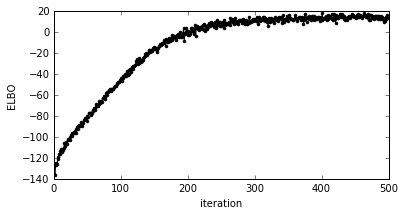

In [30]:
import time
# start time
start_time = time.time()
plt.figure(figsize=(6,3))

# optimization by tf.train
_= m_gpinv.optimize(trainer, maxiter=5000, callback=logger)

display.clear_output(wait=True)
print('Ellapsed Time is', time.time()-start_time, ' (s)')

In [31]:
X_new = np.linspace(-0.1,6.1,200).reshape(-1,1)
f_mu2, f_var2= m_gpinv.predict_f(X_new)

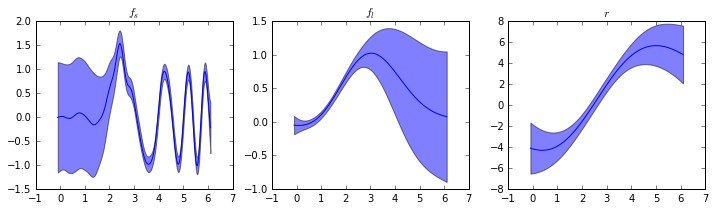

In [32]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title('$f_s$')
plt.fill_between(X_new.flatten(), f_mu2[:,0]+2.0*np.sqrt(f_var2[:,0]), f_mu2[:,0]-2.0*np.sqrt(f_var2[:,0]), alpha=0.5)
plt.plot(X_new.flatten(), f_mu2[:,0])
plt.subplot(1,3,2)
plt.title('$f_l$')
plt.fill_between(X_new.flatten(), f_mu2[:,1]+2.0*np.sqrt(f_var2[:,1]), f_mu2[:,1]-2.0*np.sqrt(f_var2[:,1]), alpha=0.5)
plt.plot(X_new.flatten(), f_mu2[:,1])
plt.subplot(1,3,3)
plt.title('$r$')
plt.fill_between(X_new.flatten(), f_mu2[:,2]+2.0*np.sqrt(f_var2[:,2]), f_mu2[:,2]-2.0*np.sqrt(f_var2[:,2]), alpha=0.5)
plt.plot(X_new.flatten(), f_mu2[:,2])

### Sample from the variational posterior

The samples from the posterior can be estimated by **sample_from** method.

In [33]:
# Here we 101 samples
sample_F = m_gpinv.sample_from_('F',101)

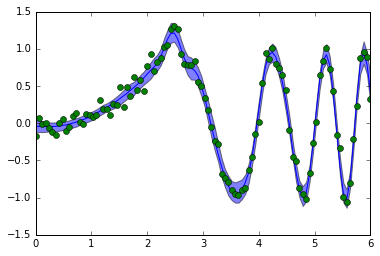

In [34]:
# plot 5-95 % range
plt.fill_between(X.flatten(),
        np.percentile(sample_F, 5, axis=0), 
        np.percentile(sample_F, 95, axis=0), alpha=0.5)
plt.plot(X.flatten(), np.median(sample_F, axis=0))
plt.plot(X, Y, 'o')

## Comparison between GPflow.gpr and GPinv.stvgp

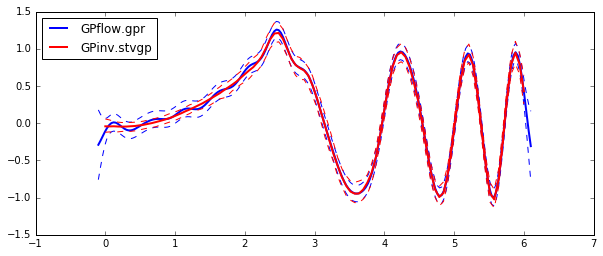

In [35]:
plt.figure(figsize=(10,4))
plt.plot(X_new, f_mu+2*np.sqrt(f_var), '--b',
         X_new, f_mu-2*np.sqrt(f_var), '--b')
plt.plot(X_new, f_mu, '-b', lw=2,label='GPflow.gpr')

plt.plot(X, np.percentile(sample_F, 5, axis=0), '--r',
         X, np.percentile(sample_F,95, axis=0), '--r')
plt.plot(X, np.median(sample_F, axis=0), '-r', lw=2,label='GPinv.stvgp')

plt.legend(loc='best')

Simple GPR overfits the data in the right region.